# Visualizing ASPECT unstructured mesh output with *yt*

In this notebook, we present initial work towards visualizing standard output from the geodynamic code ASPECT in *yt*. 

We demonstrate two methods of loading data first using a simple dataset:

1. [Manual Loading](#Manual-Loading)
2. [Loading with yt's new ASPECT frontend](#Loading-with-yt's-new-ASPECT-frontend)

The first method uses the standard *yt* release, but requires manually loading mesh and field data from `.vtu` files into memory. The second method is more experimental and uses an early draft of a *yt*-native frontend for standard ASPECT output available on the `aspect` branch of the *yt* fork [here](https://github.com/chrishavlin/yt).

After that, we show visualizations from a more complex simulation: [Visualizing fault formation in the lithosphere](#Visualizing-fault-formation-in-the-lithosphere)

## Manual Loading

In order to manually load data, we'll need the standard [*yt* release](https://yt-project.org/#getyt) along with [xmltodict](https://pypi.org/project/xmltodict/) and [meshio](https://pypi.org/project/meshio/). 

### pvtu data

The standard ASPECT vtk output is comprised of unstructured mesh data stored in `.pvtu` files: each `.pvtu` file is a timestep from the ASPECT simulation and each `.pvtu` records the `.vtu` files storing the actual data (when running in parallel, each process will output a `.vtu` file). So in order to load this data into yt manually, we need to parse our `pvtu` files to assemble `connectivity`, `coordinates`and `node_data` arrays and supply them to `load_unstructured_mesh` function: 

```python
import yt 
ds = yt.load_unstructured_mesh(
    connectivity,
    coordinates,
    node_data = node_data
)
```

The following code creates a class to parse a `.pvtu` file and accompanying `.vtu` files using a combination of [xmltodict](https://pypi.org/project/xmltodict/) and [meshio](https://pypi.org/project/meshio/). After instantiating, `pvuFile.load()` will load each `.vtu` file into memory as a separate mesh to give to `load_unstructured_mesh`:

In [11]:
import os 
import numpy as np
import xmltodict, meshio

class pvuFile(object):
    def __init__(self,file,**kwargs):
        self.file=file 
        self.dataDir=kwargs.get('dataDir',os.path.split(file)[0])
        with open(file) as data:
            self.pXML = xmltodict.parse(data.read())
            
        # store fields for convenience 
        self.fields=self.pXML['VTKFile']['PUnstructuredGrid']['PPointData']['PDataArray']     
        
        self.connectivity = None
        self.coordinates = None
        self.node_data = None
            
    def load(self):                      
    
        conlist=[]  # list of 2D connectivity arrays 
        coordlist=[] # global, concatenated coordinate array 
        nodeDictList=[] # list of node_data dicts, same length as conlist 

        con_offset=-1
        pieces = self.pXML['VTKFile']['PUnstructuredGrid']['Piece']
        if not isinstance(pieces,list):
            pieces = [pieces]
            
        for mesh_id,src in enumerate(pieces):
            print(f"processing vtu file {mesh_id+1} of {len(pieces)}")
            mesh_name="connect{meshnum}".format(meshnum=mesh_id+1) # connect1, connect2, etc.  
            
            srcFi=os.path.join(self.dataDir,src['@Source']) # full path to .vtu file 
            
            [con,coord,node_d]=self.loadPiece(srcFi,mesh_name,con_offset+1)                        
            con_offset=con.max() 
            
            conlist.append(con.astype("i8"))
            coordlist.extend(coord.astype("f8"))
            nodeDictList.append(node_d)
        
        self.connectivity=conlist
        self.coordinates=np.array(coordlist)
        self.node_data=nodeDictList
            
    def loadPiece(self,srcFi,mesh_name,connectivity_offset=0): 
        meshPiece=meshio.read(srcFi) # read it in with meshio     
        coords=meshPiece.points # coords and node_data are already global
        cell_type = list(meshPiece.cells_dict.keys())[0]
        
        connectivity=meshPiece.cells_dict[cell_type] # 2D connectivity array 

        # parse node data 
        node_data=self.parseNodeData(meshPiece.point_data,connectivity,mesh_name)

        # offset the connectivity matrix to global value 
        connectivity=np.array(connectivity)+connectivity_offset

        return [connectivity,coords,node_data]
    
    def parseNodeData(self,point_data,connectivity,mesh_name):
        
        # for each field, evaluate field data by index, reshape to match connectivity 
        con1d=connectivity.ravel() 
        conn_shp=connectivity.shape 
        
        comp_hash={0:'cx',1:'cy',2:'cz'}
        def rshpData(data1d):
            return np.reshape(data1d[con1d],conn_shp)
            
        node_data={}        
        for fld in self.fields: 
            nm=fld['@Name']
            if nm in point_data.keys():
                if '@NumberOfComponents' in fld.keys() and int(fld['@NumberOfComponents'])>1:
                    # we have a vector, deal with components
                    for component in range(int(fld['@NumberOfComponents'])): 
                        comp_name=nm+'_'+comp_hash[component] # e.g., velocity_cx 
                        m_F=(mesh_name,comp_name) # e.g., ('connect1','velocity_cx')
                        node_data[m_F]=rshpData(point_data[nm][:,component])
                else:
                    # just a scalar! 
                    m_F=(mesh_name,nm) # e.g., ('connect1','T')
                    node_data[m_F]=rshpData(point_data[nm])
    
        return node_data

Now lets set a `.pvtu` solution path then instantiate and load our `pvuFile`:

In [2]:
DataDir=os.path.join(os.environ.get('ASPECTdatadir','./'),'output_yt_vtu','solution')
pFile=os.path.join(DataDir,'solution-00000.pvtu')
if os.path.isfile(pFile) is False:
    print("data file not found")
    
pvuData=pvuFile(pFile)
pvuData.load()  

And now let's actually create a *yt* dataset:

In [3]:
import yt 
ds = yt.load_unstructured_mesh(
    pvuData.connectivity,
    pvuData.coordinates,
    node_data = pvuData.node_data,
    length_unit = 'm'
)

yt : [INFO     ] 2020-11-20 16:50:10,564 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-11-20 16:50:10,565 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-11-20 16:50:10,565 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-11-20 16:50:10,566 Parameters: domain_right_edge         = [110000. 110000. 110000.]
yt : [INFO     ] 2020-11-20 16:50:10,566 Parameters: cosmological_simulation   = 0.0


Now that we have our data loaded as a *yt* dataset, we can do some fun things. First, let's check what fields we have:

In [4]:
ds.field_list

[('all', 'T'),
 ('all', 'crust_lower'),
 ('all', 'crust_upper'),
 ('all', 'current_cohesions'),
 ('all', 'current_friction_angles'),
 ('all', 'density'),
 ('all', 'noninitial_plastic_strain'),
 ('all', 'p'),
 ('all', 'plastic_strain'),
 ('all', 'plastic_yielding'),
 ('all', 'strain_rate'),
 ('all', 'velocity_cx'),
 ('all', 'velocity_cy'),
 ('all', 'velocity_cz'),
 ('all', 'viscosity'),
 ('connect1', 'T'),
 ('connect1', 'crust_lower'),
 ('connect1', 'crust_upper'),
 ('connect1', 'current_cohesions'),
 ('connect1', 'current_friction_angles'),
 ('connect1', 'density'),
 ('connect1', 'noninitial_plastic_strain'),
 ('connect1', 'p'),
 ('connect1', 'plastic_strain'),
 ('connect1', 'plastic_yielding'),
 ('connect1', 'strain_rate'),
 ('connect1', 'velocity_cx'),
 ('connect1', 'velocity_cy'),
 ('connect1', 'velocity_cz'),
 ('connect1', 'viscosity')]

as an example of some simple functionality, we can find the min and max values of the whole domain by creating a YTRegion covering the whole domain and selecting the extrema:

In [5]:
ad = ds.all_data()

In [6]:
ad.quantities.extrema(('all','T'))

unyt_array([ 273., 1613.], '(dimensionless)')

creating slice plots is similarlly easy: 

yt : [INFO     ] 2020-11-20 16:50:15,813 xlim = 0.000000 110000.000000
yt : [INFO     ] 2020-11-20 16:50:15,815 ylim = 0.000000 110000.000000
yt : [INFO     ] 2020-11-20 16:50:15,820 xlim = 0.000000 110000.000000
yt : [INFO     ] 2020-11-20 16:50:15,820 ylim = 0.000000 110000.000000
yt : [INFO     ] 2020-11-20 16:50:15,822 Making a fixed resolution buffer of (('all', 'T')) 800 by 800



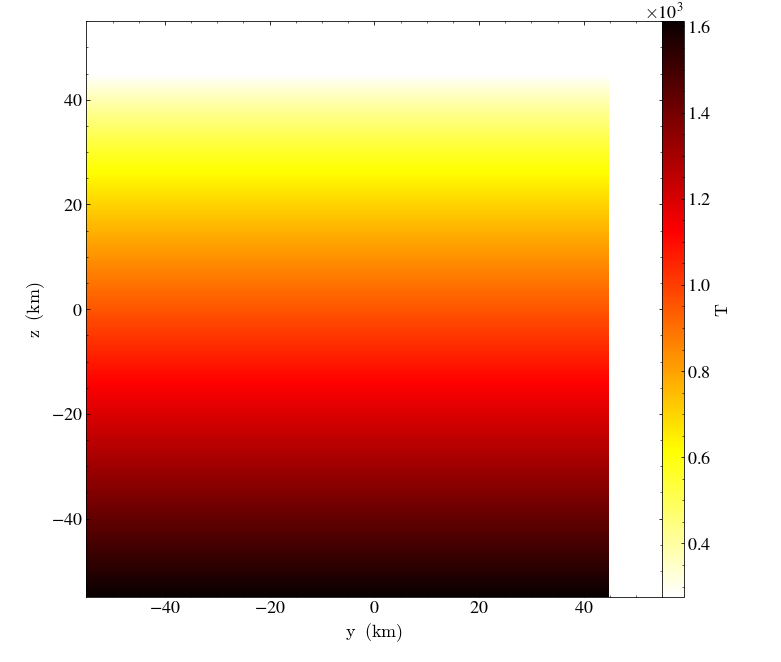

In [7]:
slc = yt.SlicePlot(ds,'x',('all','T'))
slc.set_cmap(('all','T'),'hot_r')
slc.set_log('T',False)

## Loading with yt's new ASPECT frontend

An initial draft frontend for ASPECT data is available on the `aspect` branch of the *yt* fork at: https://github.com/chrishavlin/yt. Until a PR is submitted and the `aspect` branch makes its way into the main yt repository, you can clone the fork, checkout the `aspect` branch and install from source with `pip install .` At present, you also have to manually install the meshio and xmltodict packages as for the section on [Manual Loading](#Manual-Loading). 

Once installed, we can load the data using the usual yt method:

In [8]:
import yt
ds = yt.load(pFile)

yt : [INFO     ] 2020-11-18 15:06:17,783 detected cell type is hexahedron.
yt : [INFO     ] 2020-11-18 15:06:17,843 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-11-18 15:06:17,843 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2020-11-18 15:06:17,843 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-11-18 15:06:17,844 Parameters: domain_right_edge         = [100000. 100000. 100000.]
yt : [INFO     ] 2020-11-18 15:06:17,844 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2020-11-18 15:06:17,868 detected cell type is hexahedron.


yt : [INFO     ] 2020-11-18 15:06:18,026 xlim = 0.000000 100000.000000
yt : [INFO     ] 2020-11-18 15:06:18,026 ylim = 0.000000 100000.000000
yt : [INFO     ] 2020-11-18 15:06:18,027 xlim = 0.000000 100000.000000
yt : [INFO     ] 2020-11-18 15:06:18,027 ylim = 0.000000 100000.000000
yt : [INFO     ] 2020-11-18 15:06:18,028 Making a fixed resolution buffer of (('all', 'T')) 800 by 800



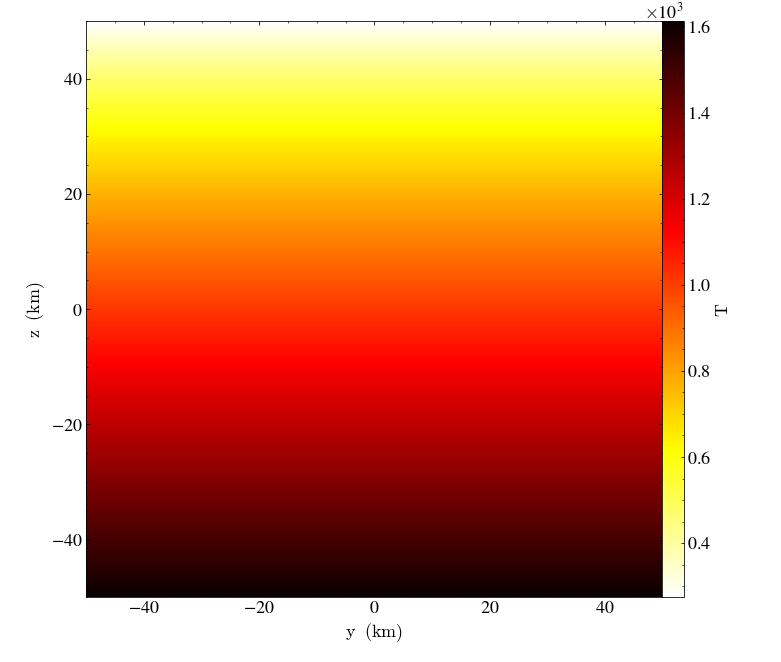

In [9]:
slc = yt.SlicePlot(ds,'x',('all','T'))
slc.set_cmap(('all','T'),'hot_r')
slc.show()

In [10]:
slc.save('figures/aspect_T_slice.png')

yt : [INFO     ] 2020-11-18 15:06:18,424 Saving plot figures/aspect_T_slice.png


['figures/aspect_T_slice.png']

yt : [INFO     ] 2020-11-18 15:06:18,587 xlim = 0.000000 100000.000000
yt : [INFO     ] 2020-11-18 15:06:18,587 ylim = 0.000000 100000.000000
yt : [INFO     ] 2020-11-18 15:06:18,588 xlim = 0.000000 100000.000000
yt : [INFO     ] 2020-11-18 15:06:18,589 ylim = 0.000000 100000.000000
yt : [INFO     ] 2020-11-18 15:06:18,590 Making a fixed resolution buffer of (('all', 'strain_rate')) 800 by 800



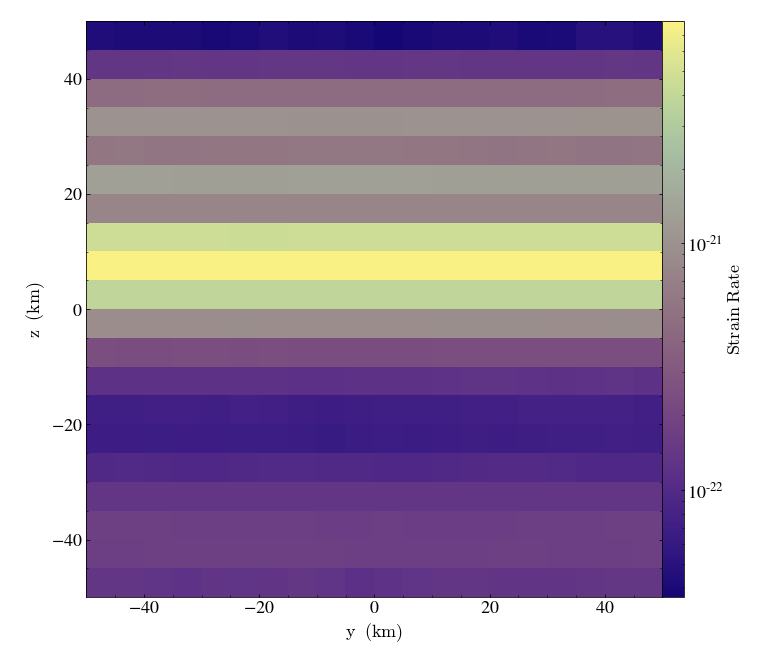

In [11]:
slc = yt.SlicePlot(ds,'x',('all','strain_rate'))
slc.set_log('strain_rate',True)
slc.set_cmap(('all','strain_rate'),'kelp')
slc.show()

As of now, the field data is not assigned units, so the color axes in these plots are unitless, but we can see we now have the expected units for the axes. 


In [12]:
slc.save('figures/aspect_sr_slice.png')

yt : [INFO     ] 2020-11-18 15:06:19,095 Saving plot figures/aspect_sr_slice.png


['figures/aspect_sr_slice.png']

## A note on higher order elements

ASPECT can output higher order hexahedral elements but at present, *yt* only supports plotting first order elements. We could truncate the hexahedral elements to the first 8 nodes (the "corner" vertices for a linear element) before loading, but we can actually let *yt* do that automatically. Since we're using `meshio` on the back end for parsing the vtu files, however, we'll need a a modified version of meshio as the current vtu support does not include parsing the higher order elements. At present, installing the `vtu72` branch of the meshio fork at `https://github.com/chrishavlin/meshio` will allow *yt* to load the higher order data (though it will not be used in plotting). 


## Visualizing fault formation in the lithosphere

The above examples are simple illustrations of loading and slicing ASPECT data with *yt*, but we can also load more complex ASPECT runs that were run in parallel. Here, we demsonstrate loading a complex simulation investigating fault formation in the lithosphere. Due to some existing bugs in the draft front end, we'll use the manual parser and the general unstructured mesh loader, `yt.load_unstructured_mesh`. 

So as before, we'll instantiate our manual loader, parse the data and the create the yt dataset:

In [9]:
DataDir=os.path.join(os.environ.get('ASPECTdatadir','./'),'fault_formation')
pFile=os.path.join(DataDir,'solution-00050.pvtu')
if os.path.isfile(pFile) is False:
    print(f"data file not found: {pFile}")

In [12]:
# instantiate our manual pvu loader and load into memory (can take a few mins!)
pvuData=pvuFile(pFile)
pvuData.load()

processing vtu file 1 of 8
processing vtu file 2 of 8
processing vtu file 3 of 8
processing vtu file 4 of 8
processing vtu file 5 of 8
processing vtu file 6 of 8
processing vtu file 7 of 8
processing vtu file 8 of 8


In [13]:
# create the yt dataset
ds = yt.load_unstructured_mesh(
    pvuData.connectivity,
    pvuData.coordinates,
    node_data = pvuData.node_data,
    length_unit="m"
)

yt : [INFO     ] 2020-11-20 16:53:50,365 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-11-20 16:53:50,366 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2020-11-20 16:53:50,366 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-11-20 16:53:50,366 Parameters: domain_right_edge         = [550000.         550000.         110602.18984375]
yt : [INFO     ] 2020-11-20 16:53:50,367 Parameters: cosmological_simulation   = 0.0


In these simulations, faults show up most clearly in strain rate, so let's take some slices. Let's start with a vertical slice through the lithosphere:

yt : [INFO     ] 2020-11-20 16:54:12,046 xlim = 0.000000 550000.000000
yt : [INFO     ] 2020-11-20 16:54:12,046 ylim = 0.000000 110602.189844
yt : [INFO     ] 2020-11-20 16:54:12,048 xlim = 0.000000 550000.000000
yt : [INFO     ] 2020-11-20 16:54:12,048 ylim = 0.000000 110602.189844
yt : [INFO     ] 2020-11-20 16:54:12,049 Making a fixed resolution buffer of (('all', 'strain_rate')) 800 by 800



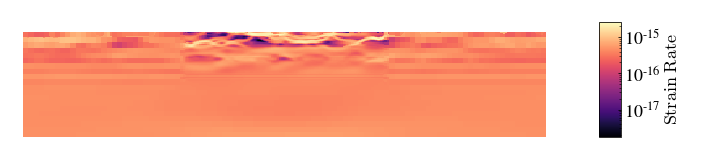

In [14]:
slc = yt.SlicePlot(ds,'x',('all','strain_rate'))
slc.set_log('strain_rate',True)
slc.set_cmap(('all','strain_rate'),'magma')
slc.hide_axes()
slc.show()

Now let's take a horizontal slice at fixed depth within the crust. To do this, we'll adjust provide a `center` argument to `SlicePlot` and set it to the domain center in `x` and `y` and set the `z` value to 80% of the maximum height: 

yt : [INFO     ] 2020-11-20 16:54:35,791 xlim = 0.000000 550000.000000
yt : [INFO     ] 2020-11-20 16:54:35,792 ylim = 0.000000 550000.000000
yt : [INFO     ] 2020-11-20 16:54:35,793 xlim = 0.000000 550000.000000
yt : [INFO     ] 2020-11-20 16:54:35,793 ylim = 0.000000 550000.000000
yt : [INFO     ] 2020-11-20 16:54:35,794 Making a fixed resolution buffer of (('all', 'strain_rate')) 800 by 800



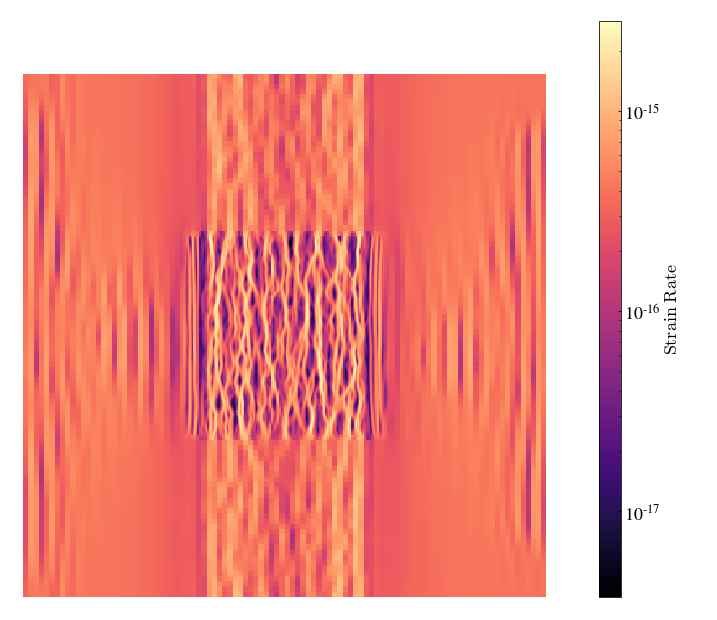

In [16]:
c_val = ds.domain_center
c_arr = np.array([c_val[0],c_val[1],ds.domain_width[2]*0.8])
slc = yt.SlicePlot(ds,'z',('all','strain_rate'),center=c_arr)
slc.set_log('strain_rate',True)
slc.set_cmap(('all','strain_rate'),'magma')
slc.hide_axes()
slc.show()

This map view shows the complex fault systems arising in this model of lithosphere extension.